# SQL Magics (Pyspark + Iceberg)

In [1]:
import duckdb
import pandas as pd
import matplotlib

In [2]:
%%sql
CREATE DATABASE IF NOT EXISTS hive.nyc;

++
||
++
++

In [3]:
%%sql
CREATE TABLE IF NOT EXISTS hive.nyc.taxis (
    VendorID              bigint,


    tpep_pickup_datetime  timestamp,
    tpep_dropoff_datetime timestamp,
    passenger_count       double,
    trip_distance         double,
    RatecodeID            double,
    store_and_fwd_flag    string,
    PULocationID          bigint,
    DOLocationID          bigint,
    payment_type          bigint,
    fare_amount           double,
    extra                 double,
    mta_tax               double,
    tip_amount            double,
    tolls_amount          double,
    improvement_surcharge double,
    total_amount          double,
    congestion_surcharge  double,
    airport_fee           double
)
USING iceberg
PARTITIONED BY (days(tpep_pickup_datetime))


++
||
++
++

In [4]:
# https://github.com/toddwschneider/nyc-taxi-data/blob/master/setup_files/raw_data_urls.txt
%cd work
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-12.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-03.parquet

/home/jovyan/work
--2023-05-23 04:52:30--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-12.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.67.246.176, 18.67.246.47, 18.67.246.186, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.67.246.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49639052 (47M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2021-12.parquet’

yellow_tripdata_202 100%[===================>]  47.34M  56.6MB/s    in 0.8s    

2023-05-23 04:52:31 (56.6 MB/s) - ‘yellow_tripdata_2021-12.parquet’ saved [49639052/49639052]

--2023-05-23 04:52:32--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.67.246.176, 18.67.246.47, 18.67.246.186, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.67.246.176

In [5]:
from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Jupyter").getOrCreate()
spark = SparkSession.builder.appName("Jupyter")\
    .config("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.3_2.13:1.2.1,org.duckdb:duckdb_jdbc:0.8.0")\
    .config("spark.hadoop.datanucleus.schema.autoCreateTables","true")\
    .config("spark.hadoop.datanucleus.schema.autoCreateSchema","true")\
    .config("spark.sql.catalog.hive","org.apache.iceberg.spark.SparkCatalog")\
    .config("spark.sql.catalog.hive.uri","thrift://metastore:9083")\
    .config("spark.sql.catalog.hive.type","hadoop")\
    .config("spark.sql.catalog.hive.warehouse","/home/jovyan/spark-datawarehouse")\
    .getOrCreate()

for filename in [
    "yellow_tripdata_2022-03.parquet",
    "yellow_tripdata_2022-02.parquet",
    "yellow_tripdata_2022-01.parquet",
    "yellow_tripdata_2021-12.parquet",
]:
    df = spark.read.parquet(f"work/{filename}").sortWithinPartitions("tpep_pickup_datetime")
    df.write.mode("append").saveAsTable("hive.nyc.taxis")


# SQL Magics (DuckDB)

In [6]:
# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

%reload_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False


%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db
%sql SELECT 'Off and flying!' as a_duckdb_column

,a_duckdb_column
0,Off and flying!


In [7]:
%%sql
SELECT
    schema_name,
    function_name
FROM duckdb_functions()
ORDER BY ALL DESC
LIMIT 5

,schema_name,function_name
0,pg_catalog,shobj_description
1,pg_catalog,pg_typeof
2,pg_catalog,pg_type_is_visible
3,pg_catalog,pg_ts_template_is_visible
4,pg_catalog,pg_ts_parser_is_visible


In [8]:
%sql my_df << SELECT 'Off and flying!' as a_duckdb_column

In [9]:


input_df = pd.DataFrame.from_dict({"i":[1, 2, 3],
                                  "j":["one", "two", "three"]})


In [10]:
%sql output_df << SELECT sum(i) as total_i FROM input_df

In [11]:
%%sql
INSTALL httpfs;
LOAD httpfs;

""


<Axes: title={'center': "'trip_distance' from 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet'"}, ylabel='trip_distance'>

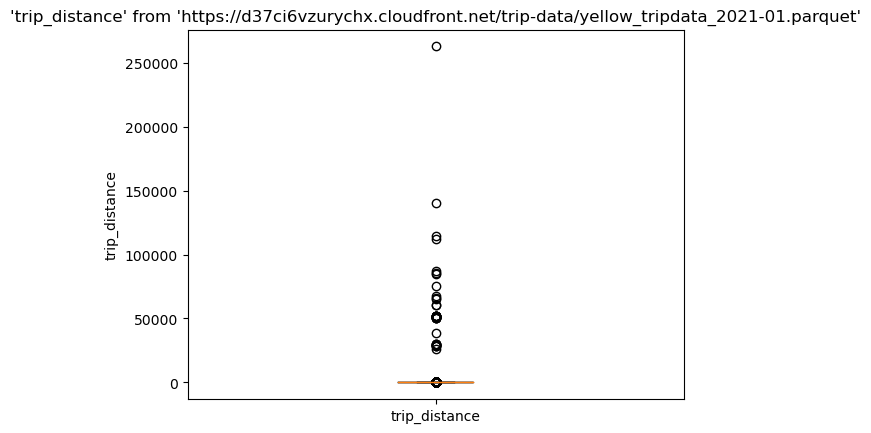

In [12]:
%sqlplot boxplot --table https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet --column trip_distance